In [91]:
import pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import hdbscan
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

In [111]:
# Load core view
p = Path("data/processed") / "hbn_core_view_v1.csv"
df = pd.read_csv(p)

In [112]:
import os

def find_project_root(start: Path | None = None) -> Path:
    """Return the repo root by searching upward for markers."""
    p = (start or Path.cwd()).resolve()
    markers = {".git", "environment.yml", "README.md"}
    while True:
        if any((p/m).exists() for m in markers):
            return p
        if p.parent == p:
            # fallback: use start if nothing found
            return (start or Path.cwd()).resolve()
        p = p.parent

# allow manual override via env var if needed (e.g., in CI/Colab)
ROOT = Path(os.environ.get("HBN_PROJ_ROOT", find_project_root()))
DATA_DIR     = ROOT / "data"
RESULTS_DIR  = ROOT / "results" / "eda"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Results dir :", RESULTS_DIR)

Project root: /Users/yizj/Desktop/hbn_project
Results dir : /Users/yizj/Desktop/hbn_project/results/eda


# Feature Selection

In [113]:
# 1) Normalize column names to prevent whitespace issues
df.columns = df.columns.str.strip()

# 2) Helper: pick the first existing column from a preference list
def pick(df, options, *, must=True):
    for c in options:
        if c in df.columns:
            return c
    if must:
        raise KeyError(f"None of these columns found: {options}")
    return None

# 3) Choose NIH columns with fallbacks
col_flank = pick(df, [
    "NIH_final,NIH_Flanker_Computed_Score",
    "NIH_final,NIH_Flanker_Age_Corr_Stnd",
    "NIH_final,NIH_Flanker_Uncorr_Stnd",
    "NIH_final,NIH_Flanker_Raw"
])

col_list  = pick(df, [
    "NIH_final,NIH_List_Sort_Computed_Score",      # not present in core csv
    "NIH_final,NIH_List_Sort_Age_Corr_Stnd",       # <- will be chosen instead
    "NIH_final,NIH_List_Sort_Uncorr_Stnd",
    "NIH_final,NIH_List_Sort_Raw"
])

col_proc  = pick(df, [
    "NIH_final,NIH_Processing_Computed_Score",
    "NIH_final,NIH_Processing_Age_Corr_Stnd",
    "NIH_final,NIH_Processing_Uncorr_Stnd",
    "NIH_final,NIH_Processing_Raw"
])

# 4) TD + demographics
td_cols   = ["logk_mean", "k_abs_diff_log"]  # add "k_mean" or "ed50_mean" later for sensitivity
demo_cols = ["Age","Sex"]

feature_cols = td_cols + [col_flank, col_list, col_proc] + demo_cols
print("Using columns:", feature_cols)

# Build X
X = df[feature_cols].copy()

# Ensure Sex is numeric 0/1
if X["Sex"].dtype == "O":
    X["Sex"] = X["Sex"].str.strip().str.lower().map({"male":1,"m":1,"female":0,"f":0})

Using columns: ['logk_mean', 'k_abs_diff_log', 'NIH_final,NIH_Flanker_Computed_Score', 'NIH_final,NIH_List_Sort_Age_Corr_Stnd', 'NIH_final,NIH_Processing_Computed_Score', 'Age', 'Sex']


# Impute Missingness

### Core view has low missingness (e.g., ~0–3.4%), so a simple robust imputer is best
- Median imputation for numeric features (logk_mean, k_abs_diff, NIH scores, Age): median is robust to skew/outliers (TD and EF scores are often skewed).
- Most frequent for Sex (if coded 0/1 or M/F): categorical → use mode.
- Avoid heavier imputers (KNN/Iterative) here; they add variance/compute and aren’t needed with low missingness.

In [114]:
num_cols = [c for c in X.columns if c != 'Sex']
cat_cols = ['Sex']

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",  StandardScaler())]),
     num_cols),
    ("cat", SimpleImputer(strategy="most_frequent"), cat_cols)
])

Xp = pre.fit_transform(X)   # numpy array with no NaNs, scaled numerics
print("Transformed shape:", Xp.shape)

Transformed shape: (1975, 7)


In [115]:
# Missingness before
miss = X.isna().mean().sort_values(ascending=False)
display(miss.to_frame("missing_pct"))

# Which cells were imputed (per column)
imputed_counts = {}
for i, col in enumerate(num_cols + cat_cols):
    # build mask of rows that were missing before imputation
    was_na = X[col].isna().values
    imputed_counts[col] = was_na.sum()
pd.Series(imputed_counts).sort_values(ascending=False)

,missing_pct
k_abs_diff_log,0.033924
Age,0.000506
Sex,0.000506
logk_mean,0.000000
"NIH_final,NIH_Flanker_Computed_Score",0.000000
"NIH_final,NIH_List_Sort_Age_Corr_Stnd",0.000000
"NIH_final,NIH_Processing_Computed_Score",0.000000


k_abs_diff_log                             67
Age                                         1
Sex                                         1
logk_mean                                   0
NIH_final,NIH_Flanker_Computed_Score        0
NIH_final,NIH_List_Sort_Age_Corr_Stnd       0
NIH_final,NIH_Processing_Computed_Score     0
dtype: int64

## Build imputed-original DataFrame (no scaling) for profiles
Construct an imputed (unscaled) DataFrame for readable cluster profiles in original units.

In [116]:
# Reuse the fitted imputers inside your pipeline to get original-unit values
num_imp = pre.named_transformers_["num"].named_steps["imp"]
cat_imp = pre.named_transformers_["cat"]

num_imp_vals = num_imp.transform(X[num_cols])                 # imputed numerics (no scaling)
cat_imp_vals = cat_imp.transform(X[cat_cols])                 # imputed Sex
X_imp_orig = pd.DataFrame(
    np.c_[num_imp_vals, cat_imp_vals],
    columns=num_cols + cat_cols,
    index=X.index
)
# Ensure Sex is numeric 0/1
X_imp_orig["Sex"] = pd.to_numeric(X_imp_orig["Sex"], errors="coerce").astype("float")
X_imp_orig.head()

,logk_mean,k_abs_diff_log,"NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Computed_Score",Age,Sex
0,-9.119458,0.000000,7.66,59.0,36.0,21.216746,1.0
1,-5.706448,4.952615,6.34,82.0,28.0,9.165297,1.0
2,-8.651107,0.936703,7.39,100.0,48.0,10.793862,1.0
3,-8.176825,1.556754,5.19,109.0,15.0,5.805384,0.0
4,3.178054,0.000000,4.63,75.0,21.0,5.055213,0.0


# Helpers: PCA scatter + profile heatmap

In [117]:
def pca_scatter(array, labels, title="PCA scatter"):
    pc = PCA(n_components=2, random_state=0).fit_transform(array)
    fig, ax = plt.subplots(figsize=(5.2, 3.6), dpi=200)
    for c in np.unique(labels):
        m = labels == c
        ax.scatter(pc[m,0], pc[m,1], s=10, alpha=0.85, label=f"Cluster {int(c)}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_title(title)
    ax.grid(True, lw=0.3); ax.legend(frameon=True, fontsize=8)
    plt.show()

In [118]:
def profile_table_and_heatmap_mixed(
    df_original,          # imputed DataFrame (Age in yrs, Sex numeric 0/1 or {M/F})
    labels,               # 1D array-like cluster labels (len == len(df_original))
    z_cols,               # columns to summarize in z-units (TD + NIH features)
    age_col="Age",
    sex_col="Sex",
    title="Cluster profiles (mixed units: Age yrs, Sex %M, others z)"
):
    df_ = df_original.copy()

    # Ensure Sex is numeric 0/1 (1 = male) for proportions
    if df_[sex_col].dtype == 'O':
        df_[sex_col] = (df_[sex_col].astype(str).str.strip().str.lower()
                        .map({'male':1,'m':1,'female':0,'f':0}))
    df_[sex_col] = pd.to_numeric(df_[sex_col], errors="coerce")

    # ----------------------------
    # 1) Profile table to DISPLAY
    # ----------------------------
    # Age (yrs) + Sex (% male)
    prof_age = df_.groupby(labels)[age_col].mean().rename("Age (yrs)")
    prof_sex = (100 * df_.groupby(labels)[sex_col].mean()).rename("Sex (%M)")

    # Population z for feature columns (robust to constant vars)
    mean_z = df_[z_cols].mean()
    std_z  = df_[z_cols].std(ddof=0).replace(0, np.nan)
    Z = (df_[z_cols] - mean_z) / std_z
    prof_z = Z.groupby(labels).mean()

    # Combined table (Age yrs, Sex %, and z-means)
    prof = pd.concat([prof_age, prof_sex, prof_z], axis=1).round(2)
    display(prof.style.set_caption(title))

    # --------------------------------------
    # 2) Color matrix (all columns in z units)
    # --------------------------------------
    # Age & Sex: population z for color only (numbers stay in yrs/%)
    age_mean, age_std = df_[age_col].mean(), df_[age_col].std(ddof=0)
    age_std = age_std if age_std != 0 else np.nan
    z_age = ((df_[age_col] - age_mean) / age_std)

    sex_mean, sex_std = df_[sex_col].mean(), df_[sex_col].std(ddof=0)
    sex_std = sex_std if sex_std != 0 else np.nan
    z_sex = ((df_[sex_col] - sex_mean) / sex_std)

    # Cluster means in z units for Age/Sex
    prof_age_z = z_age.groupby(labels).mean().to_frame("Age_z")
    prof_sex_z = z_sex.groupby(labels).mean().to_frame("Sex_z")

    # Build color matrix: Age_z, Sex_z, and z cols (already z means)
    prof_z_for_color = pd.concat([prof_age_z, prof_sex_z, prof_z], axis=1)
    Mz = prof_z_for_color.to_numpy(float)

    # Robust symmetric limits: 95th percentile of |z|
    with np.errstate(invalid='ignore'):
        vmax = np.nanpercentile(np.abs(Mz), 95)
    if not np.isfinite(vmax) or vmax < 0.5:
        vmax = 2.0  # fallback/default
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)

    # ----------------------------
    # 3) Heatmap with annotations
    # ----------------------------
    fig, ax = plt.subplots(figsize=(9.2, 3.8), dpi=220)
    im = ax.imshow(Mz, aspect="auto", cmap="RdBu_r", norm=norm)

    # Axis labels
    heatmap_cols = ["Age_z", "Sex_z"] + list(prof_z.columns)  # color columns order
    ax.set_yticks(range(Mz.shape[0])); ax.set_yticklabels([f"Cluster {i}" for i in prof.index])
    ax.set_xticks(range(Mz.shape[1])); ax.set_xticklabels(heatmap_cols, rotation=45, ha="right")

    # Cell text: show readable units (yrs, %, z)
    for i in range(prof.shape[0]):
        for j, col in enumerate(heatmap_cols):
            if col == "Age_z":
                txt = f"{prof.iloc[i]['Age (yrs)']:.1f}"
                zval = Mz[i, j]
            elif col == "Sex_z":
                txt = f"{prof.iloc[i]['Sex (%M)']:.0f}%"
                zval = Mz[i, j]
            else:
                val = prof.iloc[i][col]  # already z-units for feature cols
                txt = f"{val:.2f}"
                zval = Mz[i, j]
            txt_color = "black" if abs(zval) < 0.6*vmax else "white"
            ax.text(j, i, txt, ha="center", va="center", color=txt_color, fontsize=8)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(f"Cluster mean (z vs population), limits ±{vmax:.2g}")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [119]:
z_cols = [
    "logk_mean","k_abs_diff_log",
    "NIH_final,NIH_Flanker_Computed_Score",
    "NIH_final,NIH_List_Sort_Age_Corr_Stnd",
    "NIH_final,NIH_Processing_Computed_Score"
]

# Clustering

## (A) K-Means 

Silhouette ∈ [-1,1]; higher = tighter clusters and larger gaps between them.
- < 0.20: weak/no clear structure
- 0.20–0.35: moderate structure (usable but expect overlap)
- 0.35–0.50: good separation
- 0.50 + : strong separation

,cluster,n,percent
0,0,754,38.2
1,1,559,28.3
2,2,662,33.5


Silhouette (k=3): 0.169


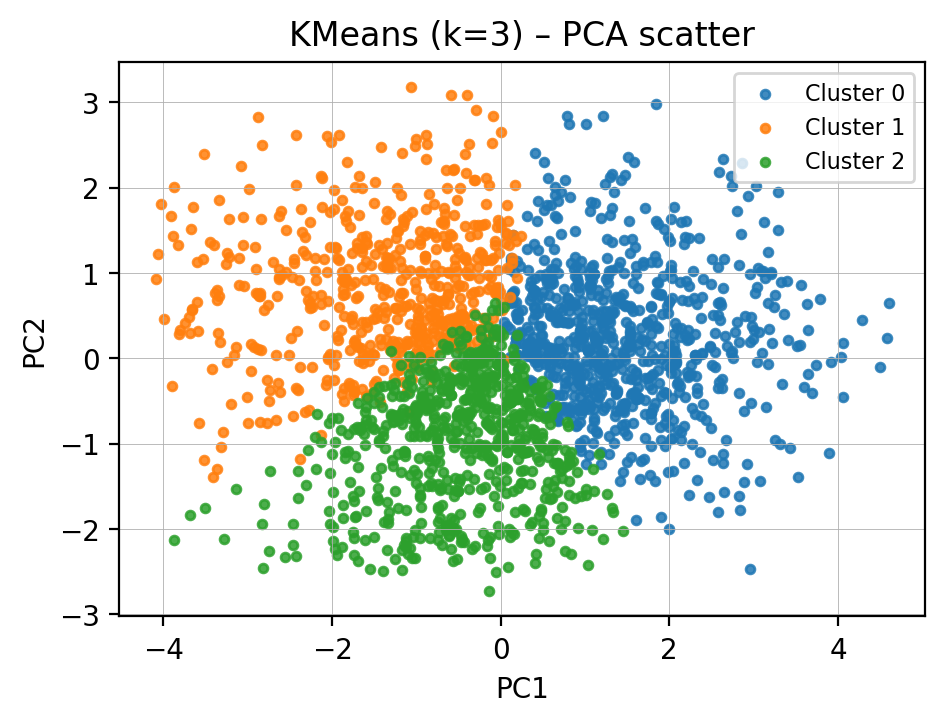

,Age (yrs),Sex (%M),logk_mean,k_abs_diff_log,"NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Computed_Score"
0,13.460000,33.690000,0.120000,-0.070000,0.710000,0.390000,0.900000
1,8.120000,32.200000,0.720000,0.690000,-0.780000,-0.390000,-0.710000
2,9.020000,36.400000,-0.750000,-0.500000,-0.150000,-0.120000,-0.430000


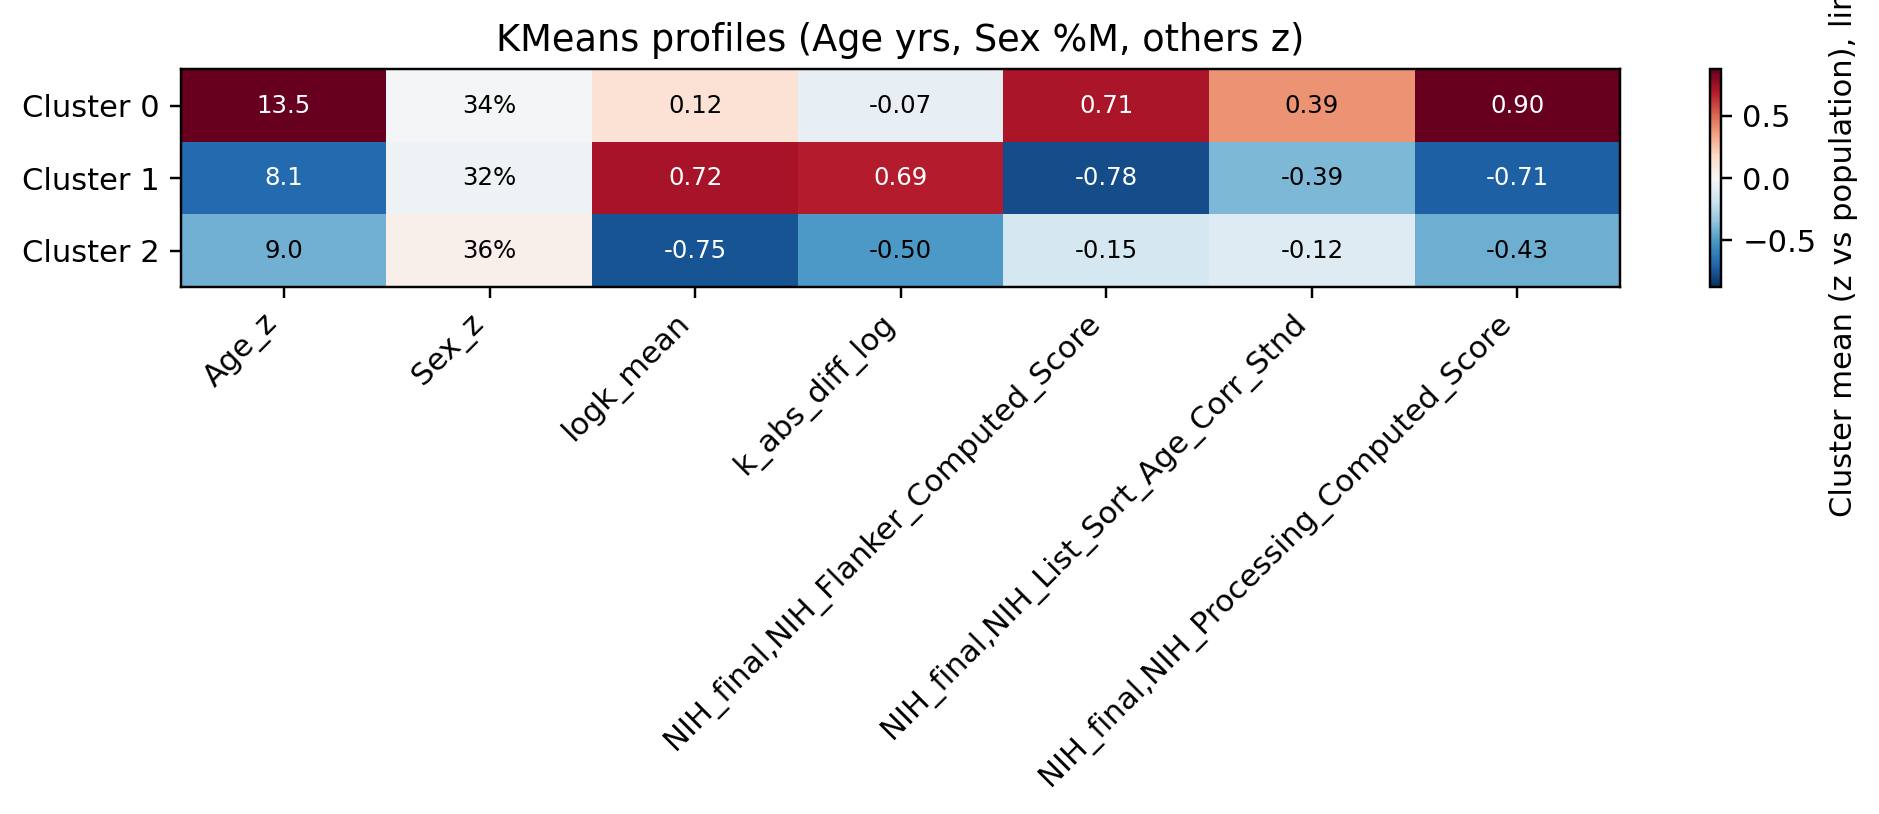

In [120]:
k = 3
km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(Xp)
lab_km = km.labels_

# Quality & sizes
sil = silhouette_score(Xp, lab_km)
sizes = pd.Series(lab_km).value_counts().sort_index().rename("n")
display(pd.DataFrame({"cluster": sizes.index, "n": sizes.values, "percent": (sizes.values/len(lab_km)*100).round(1)}))
print(f"Silhouette (k={k}): {sil:.3f}")

# Plots
pca_scatter(Xp, lab_km, title=f"KMeans (k={k}) – PCA scatter")
profile_table_and_heatmap_mixed(
    df_original=X_imp_orig,   # imputed-but-unscaled table
    labels=lab_km,            # KMeans labels
    z_cols=z_cols,
    age_col="Age",
    sex_col="Sex",
    title="KMeans profiles (Age yrs, Sex %M, others z)"
)

## (B) Gaussian Mixture (model-based / “LPA-like”)
Handles elliptical clusters and gives BIC to choose k/shape.

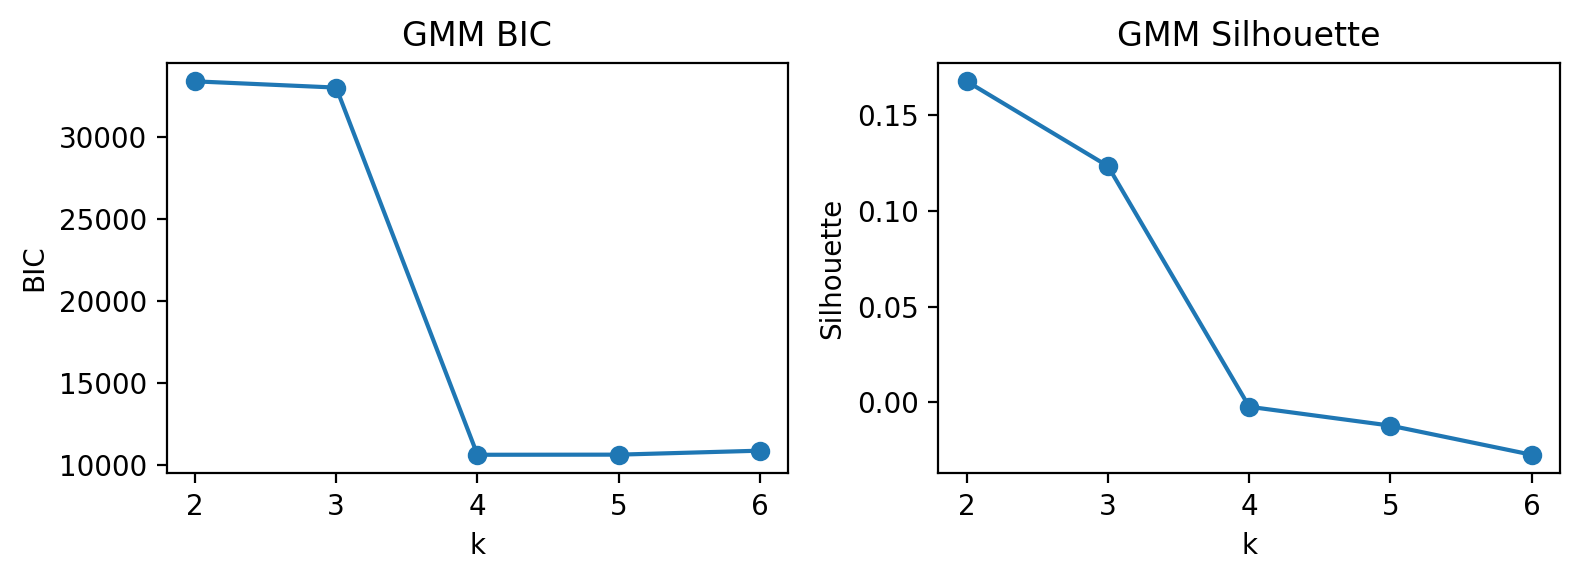

GMM silhouette (k=2): 0.168


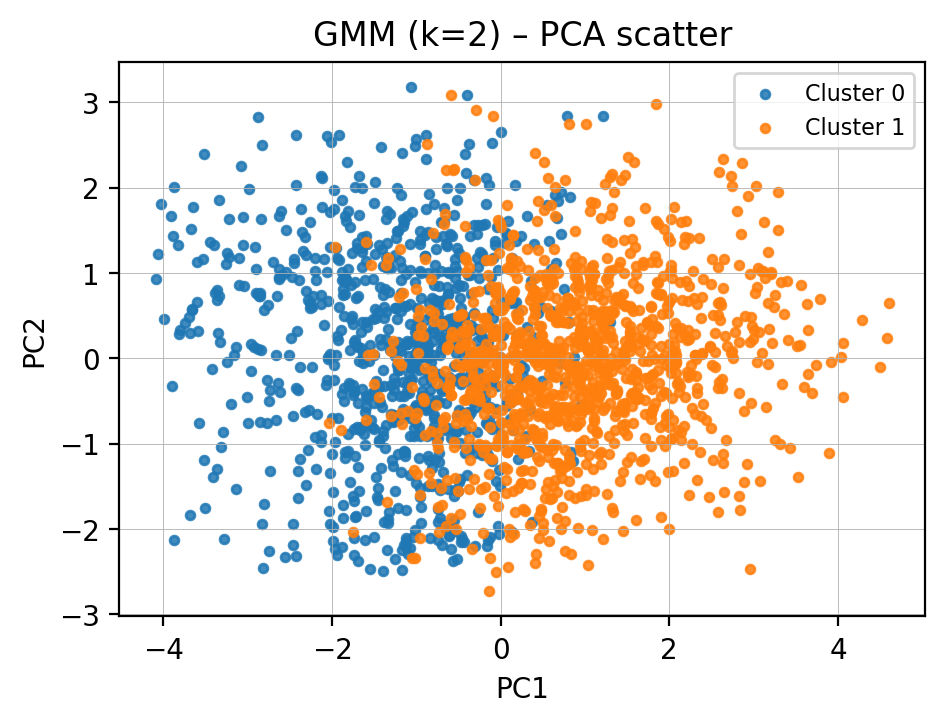

,Age (yrs),Sex (%M),logk_mean,k_abs_diff_log,"NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Computed_Score"
0,7.810000,39.880000,0.060000,0.300000,-0.630000,-0.290000,-0.640000
1,12.450000,29.910000,-0.050000,-0.220000,0.470000,0.220000,0.480000


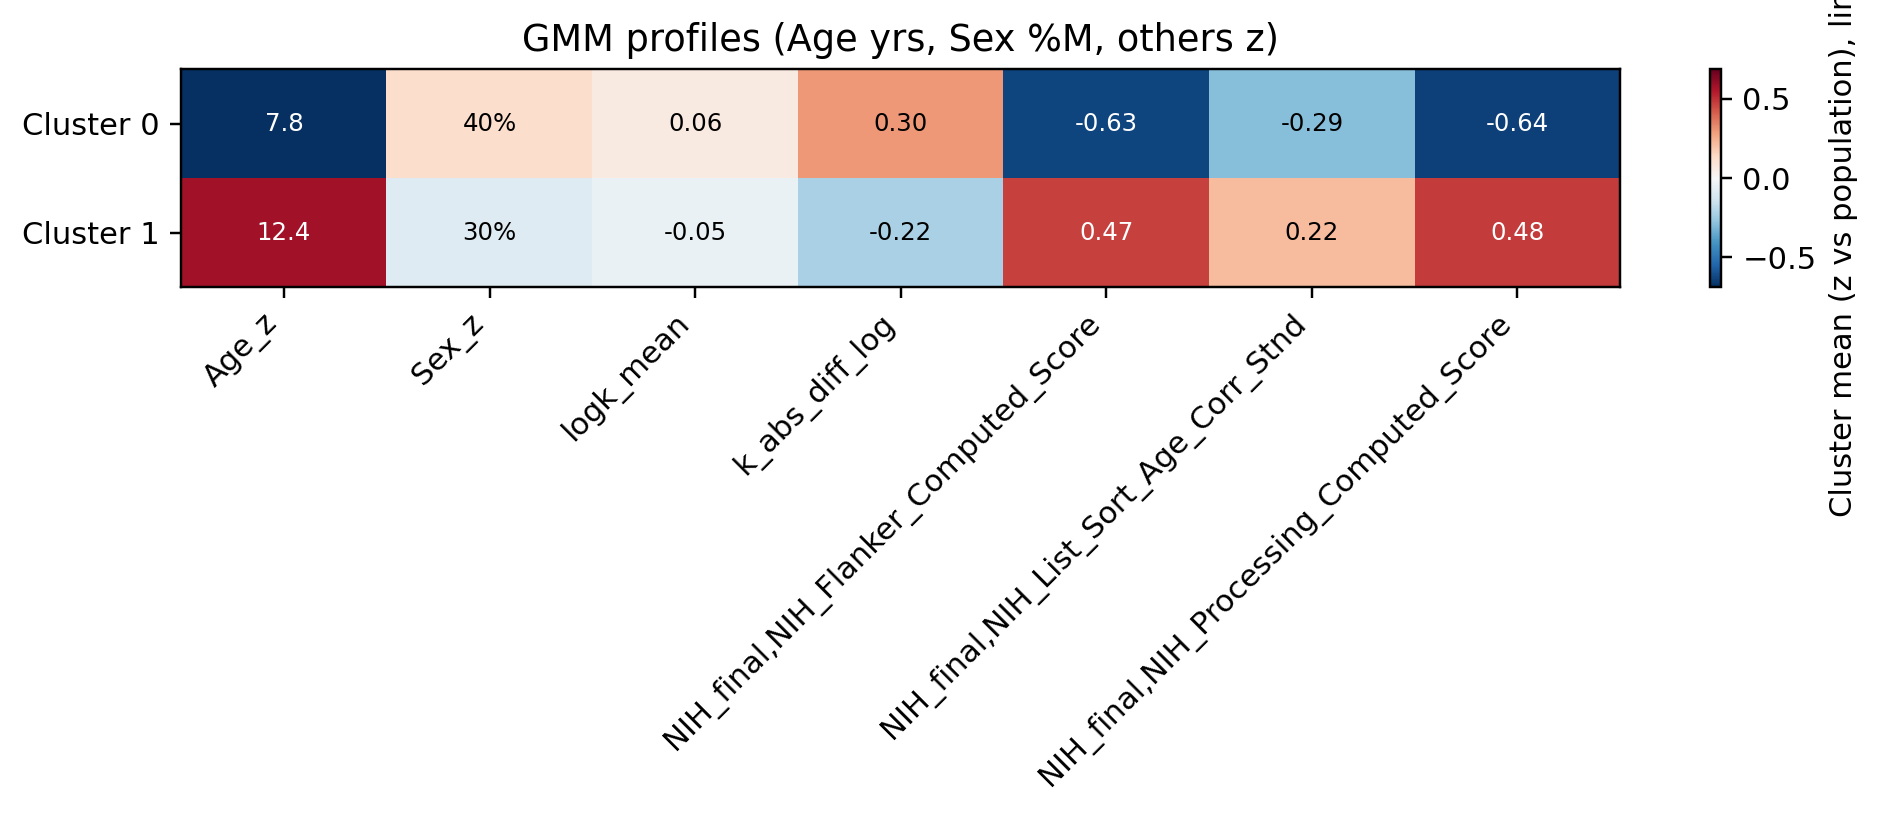

In [124]:
# Choose k via BIC (inline plot)
ks = range(2,7)
bics, sils = [], []
for kk in ks:
    g = GaussianMixture(n_components=kk, covariance_type="full", random_state=0).fit(Xp)
    bics.append(g.bic(Xp))
    lab = g.predict(Xp)
    sils.append(silhouette_score(Xp, lab))

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=200)
ax[0].plot(ks, bics, marker="o"); ax[0].set_title("GMM BIC"); ax[0].set_xlabel("k"); ax[0].set_ylabel("BIC")
ax[1].plot(ks, sils, marker="o"); ax[1].set_title("GMM Silhouette"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
fig.tight_layout(); plt.show()

# Fit for chosen k (k=2)
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0).fit(Xp)
lab_gmm = gmm.predict(Xp)
print(f"GMM silhouette (k={2}): {silhouette_score(Xp, lab_gmm):.3f}")

pca_scatter(Xp, lab_gmm, title=f"GMM (k={2}) – PCA scatter")
profile_table_and_heatmap_mixed(
    df_original=X_imp_orig,   
    labels=lab_gmm,            
    z_cols=z_cols,
    age_col="Age",
    sex_col="Sex",
    title="GMM profiles (Age yrs, Sex %M, others z)"
)

## (C) Agglomerative (Ward) on PCs
Good when clusters are roughly convex; avoids random init.

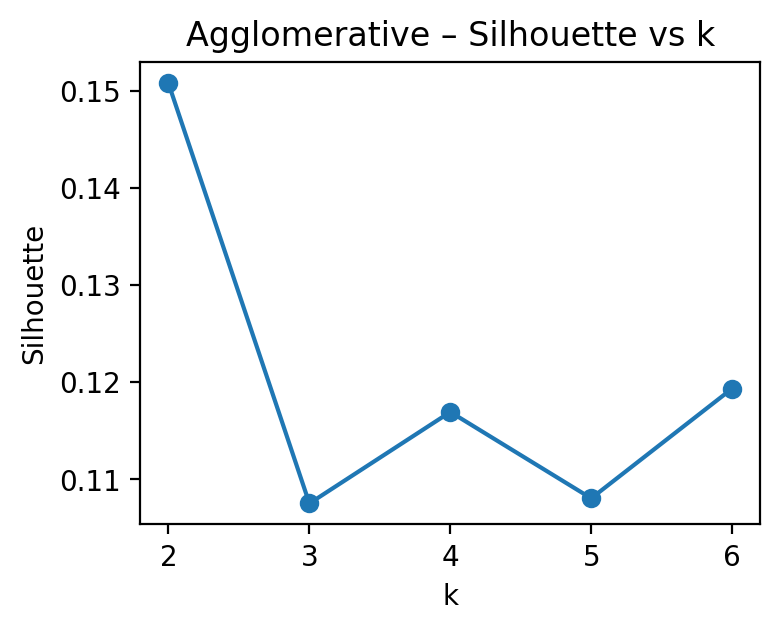

Agglomerative silhouette (k=2): 0.151


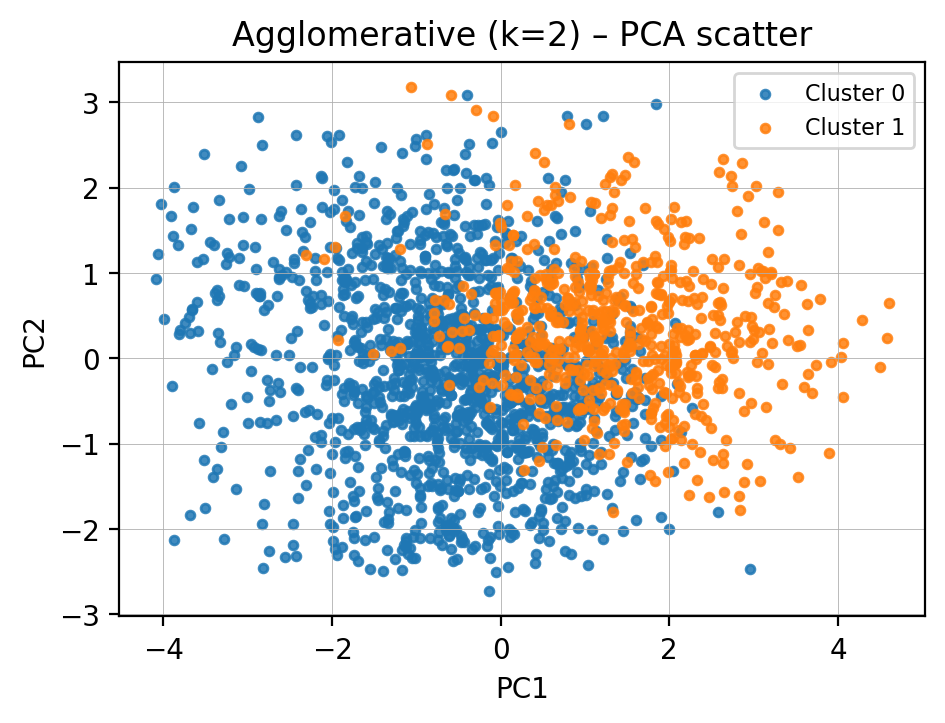

,Age (yrs),Sex (%M),logk_mean,k_abs_diff_log,"NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Computed_Score"
0,8.890000,34.420000,-0.010000,-0.040000,-0.290000,-0.040000,-0.430000
1,13.870000,33.650000,0.010000,0.100000,0.630000,0.090000,0.930000


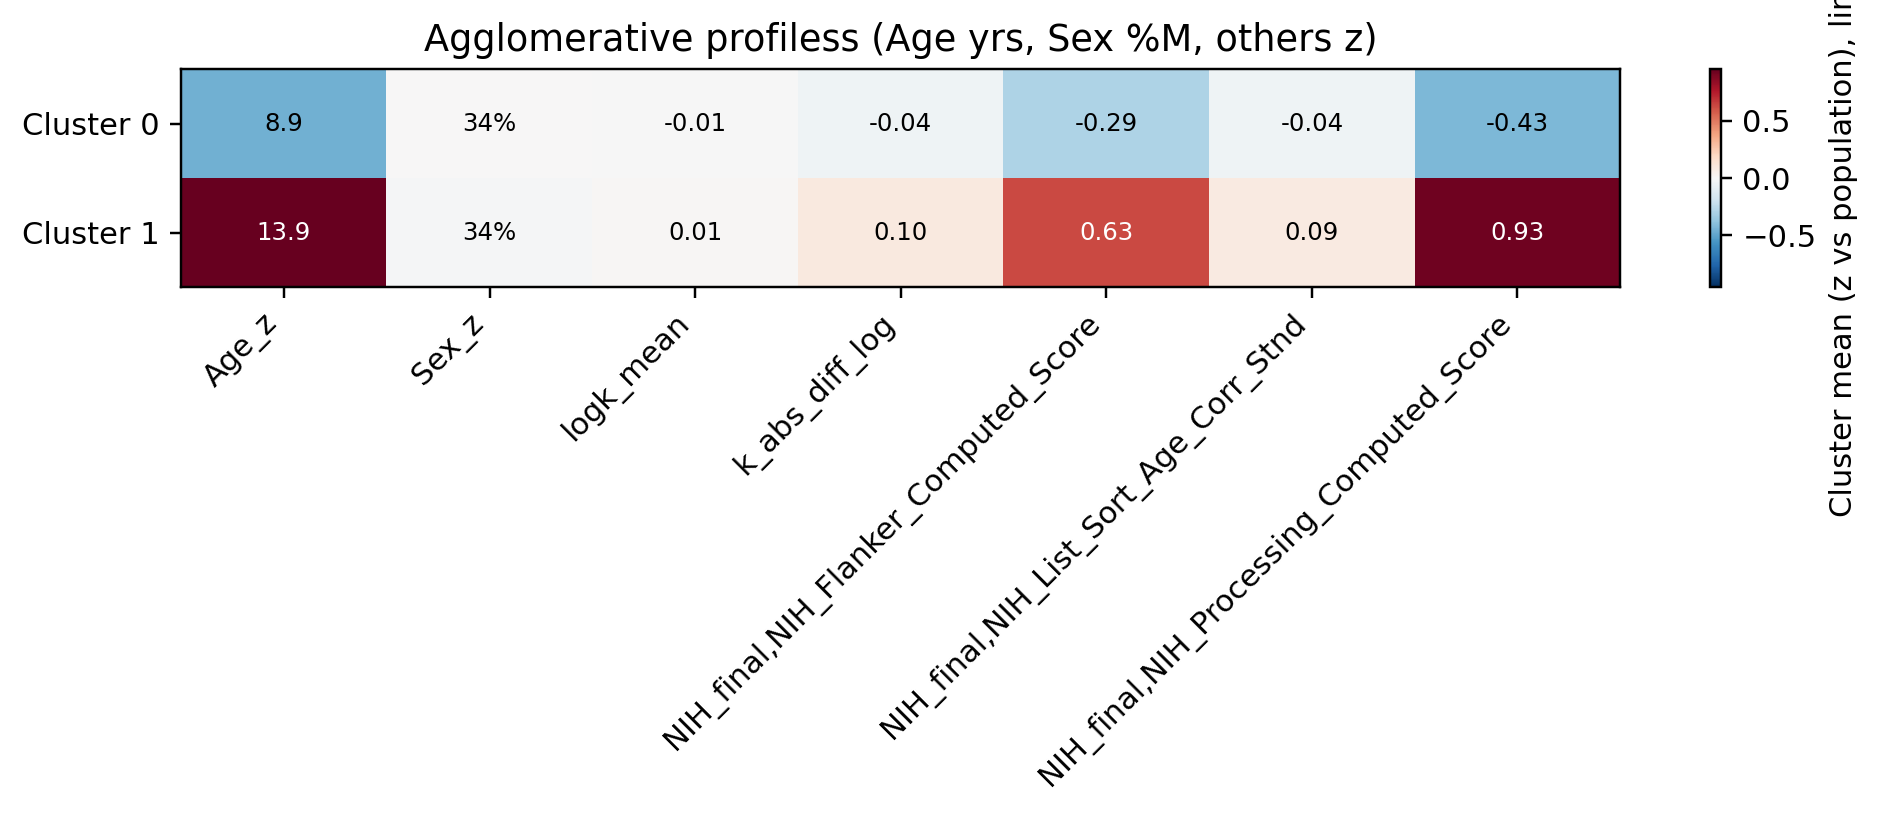

In [126]:
ks = range(2,7)
sils = []
for kk in ks:
    lab = AgglomerativeClustering(n_clusters=kk, linkage="ward").fit_predict(Xp)
    sils.append(silhouette_score(Xp, lab))
plt.figure(figsize=(4,3), dpi=200); plt.plot(ks, sils, marker="o")
plt.title("Agglomerative – Silhouette vs k"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.show()

lab_agg = AgglomerativeClustering(n_clusters=2, linkage="ward").fit_predict(Xp)
print(f"Agglomerative silhouette (k=2): {silhouette_score(Xp, lab_agg):.3f}")
pca_scatter(Xp, lab_agg, title="Agglomerative (k=2) – PCA scatter")

profile_table_and_heatmap_mixed(
    df_original=X_imp_orig,   
    labels=lab_agg,            
    z_cols=z_cols,
    age_col="Age",
    sex_col="Sex",
    title="Agglomerative profiless (Age yrs, Sex %M, others z)"
)

## 4) Density clustering to find a small “unstable discounter” group

HDBSCAN clusters (excl. noise): [0 1]


/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


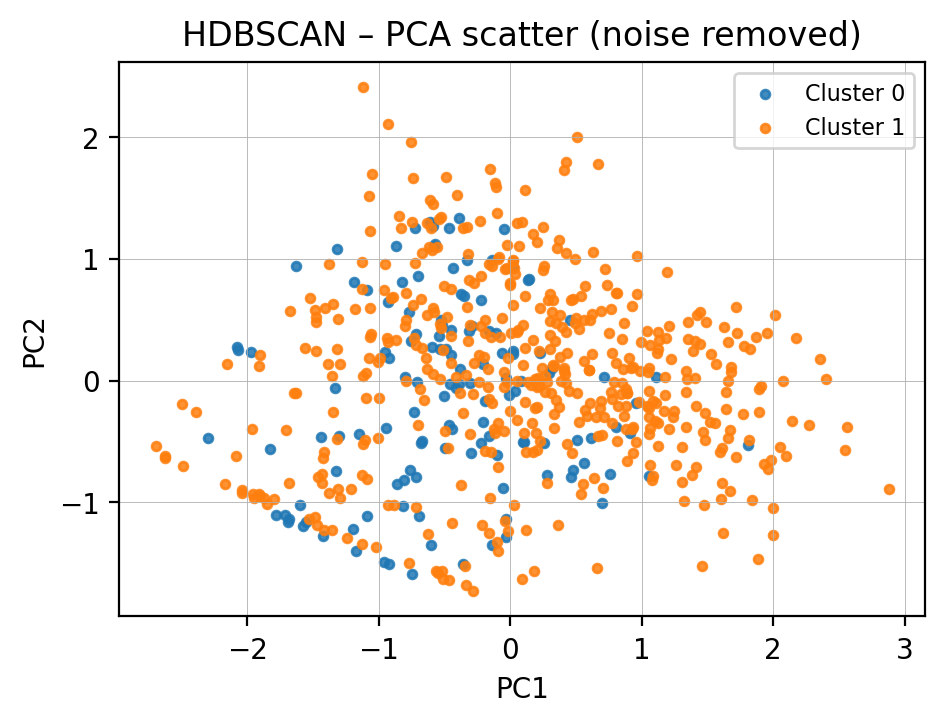

,Age (yrs),Sex (%M),logk_mean,k_abs_diff_log,"NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Computed_Score"
0,9.230000,100.000000,-0.280000,-0.250000,-0.260000,-0.400000,-0.190000
1,10.030000,0.000000,0.080000,0.070000,0.070000,0.110000,0.050000


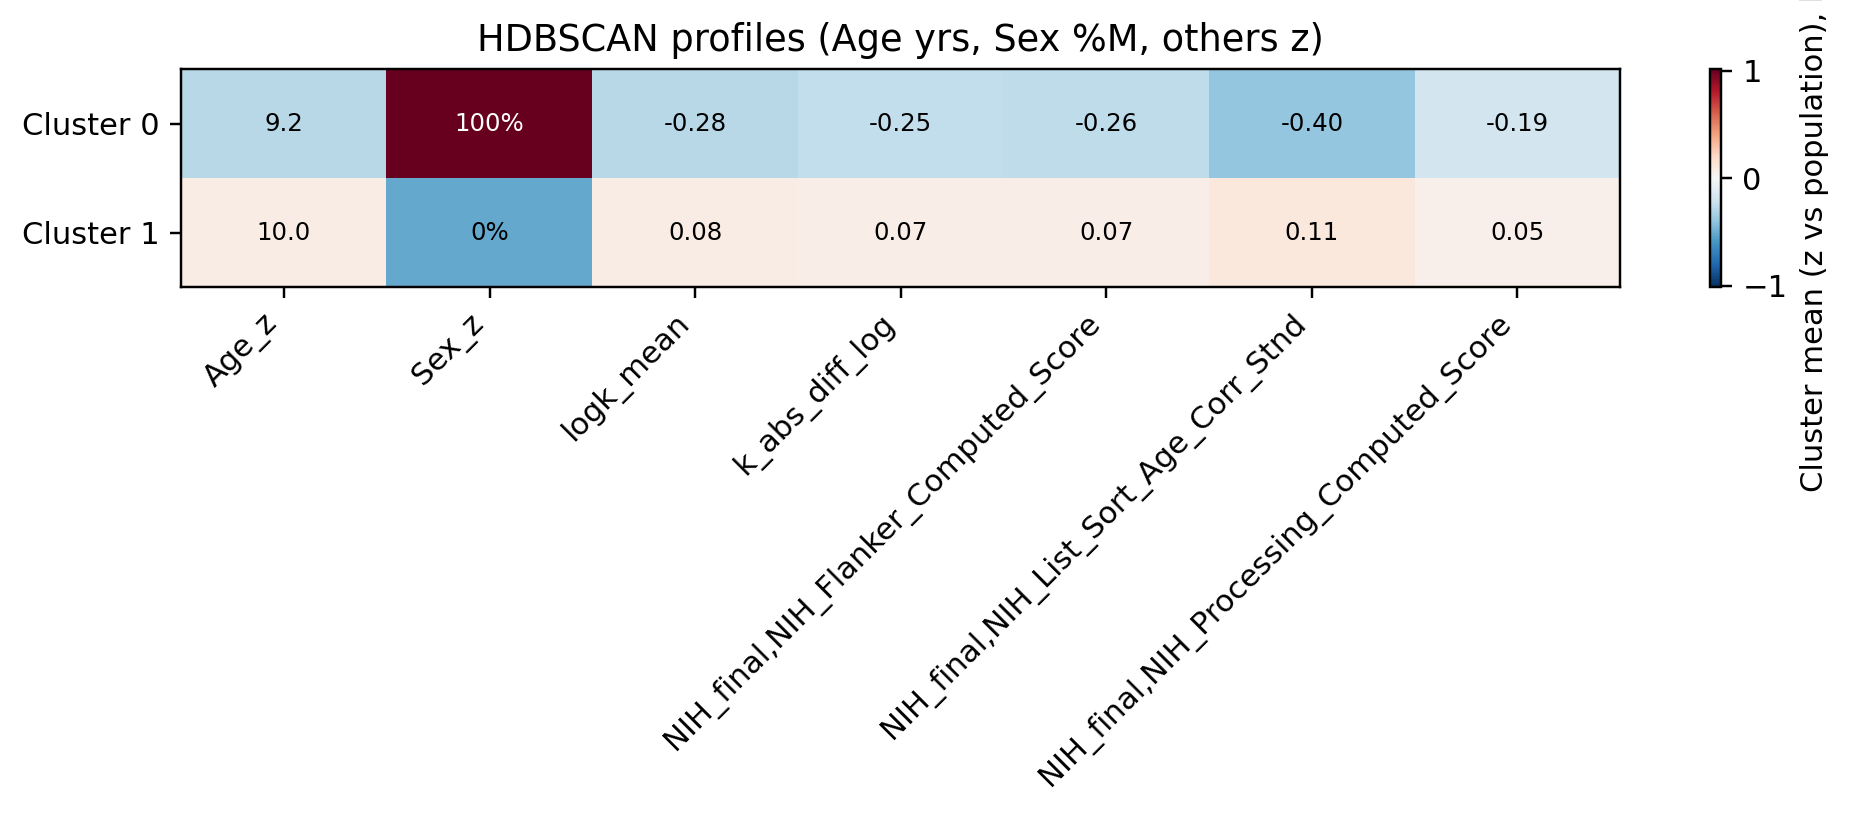

In [128]:
hdb = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10).fit(Xp)
lab_hdb = hdb.labels_
keep = lab_hdb >= 0
print("HDBSCAN clusters (excl. noise):", np.unique(lab_hdb[keep]))
if keep.any():
    pca_scatter(Xp[keep], lab_hdb[keep], title="HDBSCAN – PCA scatter (noise removed)")
    
    profile_table_and_heatmap_mixed(
    df_original=X_imp_orig.iloc[keep],   
    labels=lab_hdb[keep],            
    z_cols=z_cols,
    age_col="Age",
    sex_col="Sex",
    title="HDBSCAN profiles (Age yrs, Sex %M, others z)"
)

## Visualize how TD metrics differ across clusters
Helper function:

In [129]:
def td_boxplots(df, labels, metrics=("logk_mean","k_abs_diff"), title="TD metrics by cluster"):
    plot_df = df.loc[:, metrics].copy()
    plot_df["cluster"] = np.asarray(labels)

    # If using DBSCAN, remove noise points
    if (plot_df["cluster"] == -1).any():
        plot_df = plot_df[plot_df["cluster"] != -1]

    long = plot_df.melt(id_vars="cluster", value_vars=list(metrics),
                        var_name="TD_metric", value_name="value")

    plt.figure(figsize=(6.5, 3.6), dpi=200)
    ax = sns.boxplot(data=long, x="TD_metric", y="value", hue="cluster")
    sns.stripplot(data=long, x="TD_metric", y="value", hue="cluster",
                  dodge=True, size=2, alpha=0.35, linewidth=0, legend=False)
    ax.set_title(title)
    ax.set_xlabel("TD metric")
    ax.set_ylabel("Value (original units)")
    plt.tight_layout()
    plt.show()

KMeans       sizes: {0: 754, 1: 559, 2: 662}
KMeans silhouette (k=3): 0.169


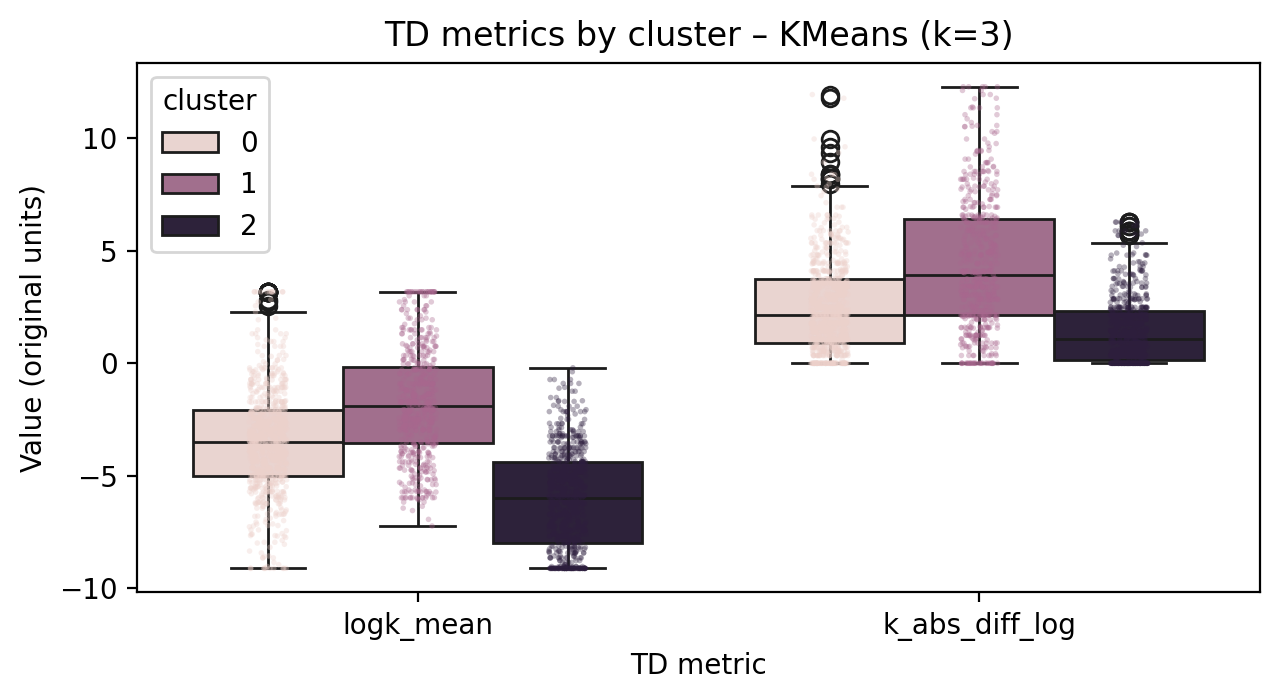

GMM          sizes: {0: 845, 1: 1130}
GMM silhouette (k=3): 0.168


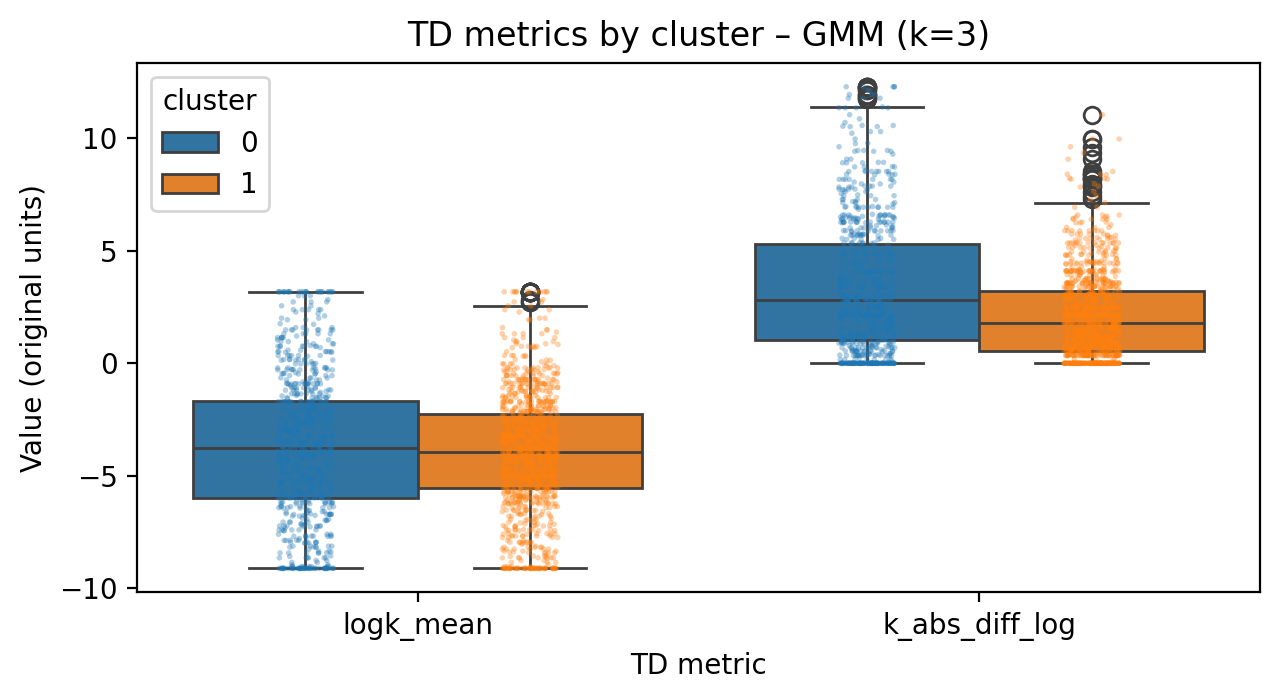

Agglo        sizes: {0: 1351, 1: 624}
Agglo silhouette (k=3): 0.151


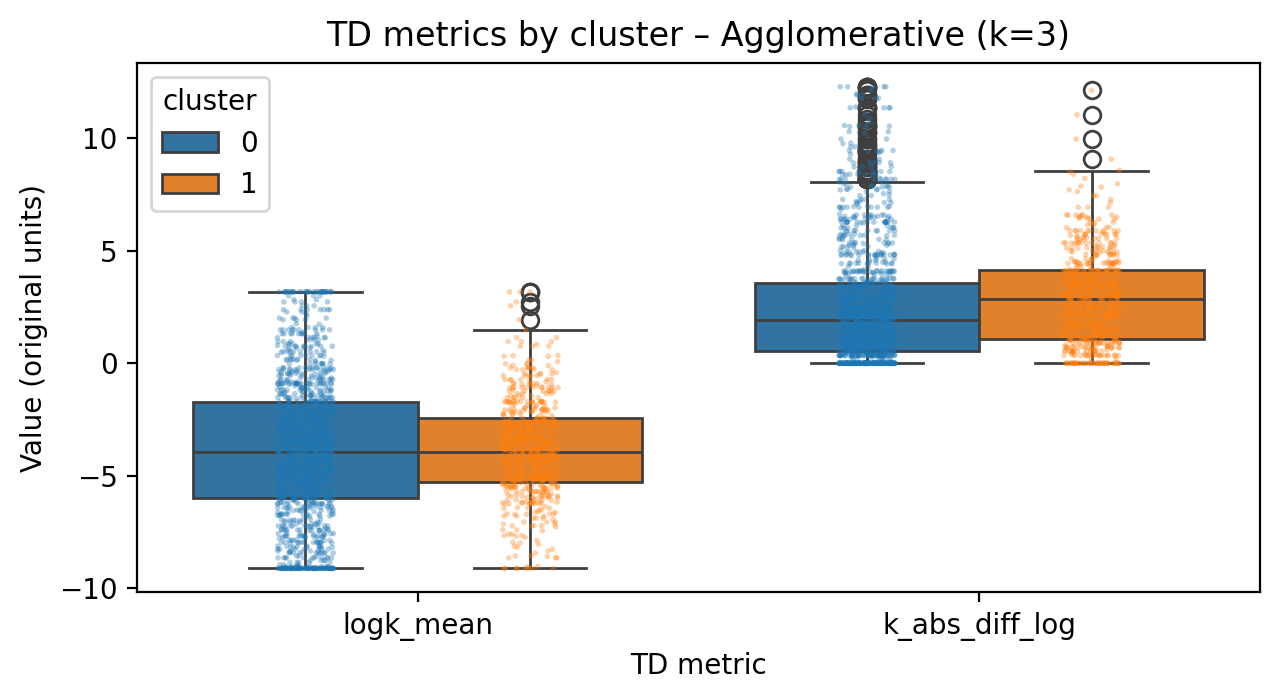

HDBSCAN      sizes: {-1: 1366, 0: 129, 1: 480}
HDBSCAN silhouette (core): 0.084


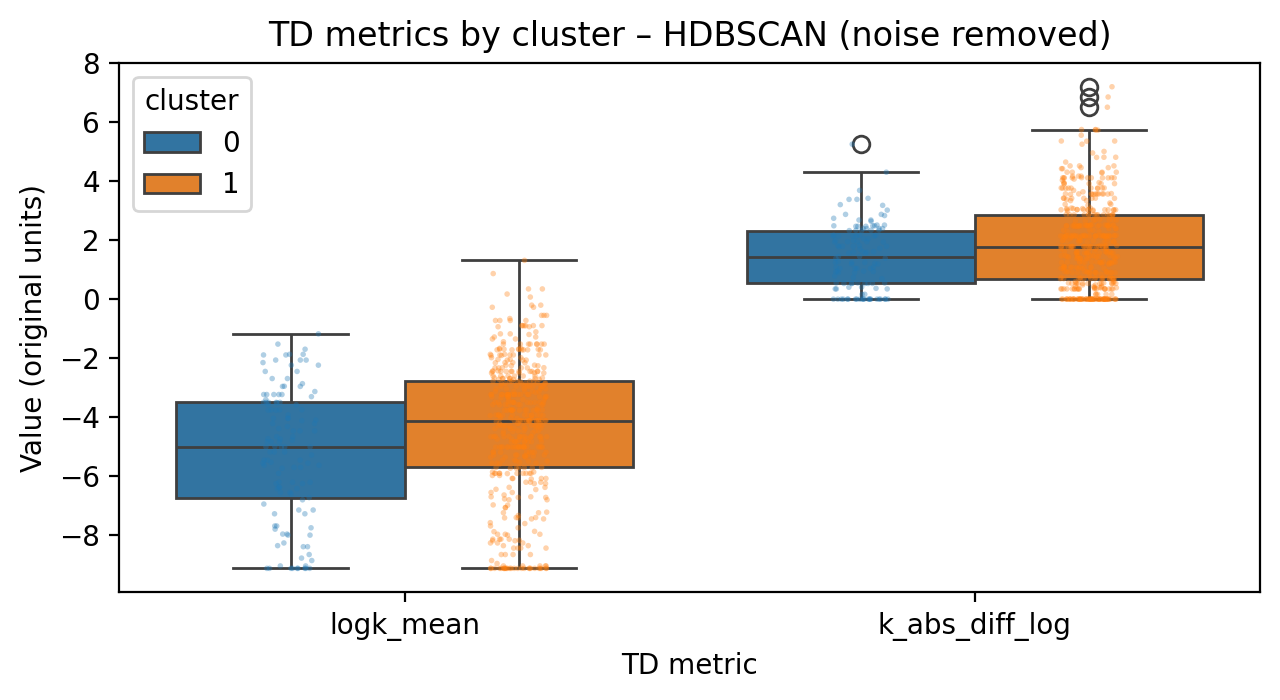

In [132]:
def print_sizes(labels, name):
    vals, cnts = np.unique(labels, return_counts=True)
    print(f"{name:12s} sizes:", dict(zip(vals, cnts)))

# --- KMEANS ---
print_sizes(lab_km, "KMeans")
try:
    print(f"KMeans silhouette (k={k}): {silhouette_score(Xp, lab_km):.3f}")
except Exception as e:
    print("KMeans silhouette not computed:", e)

td_boxplots(X_imp_orig, lab_km,
            metrics=("logk_mean","k_abs_diff_log"),
            title=f"TD metrics by cluster – KMeans (k={k})")

# --- GMM ---
print_sizes(lab_gmm, "GMM")
# you already printed one; here’s a guard just in case
try:
    print(f"GMM silhouette (k={k}): {silhouette_score(Xp, lab_gmm):.3f}")
except Exception as e:
    print("GMM silhouette not computed:", e)

td_boxplots(X_imp_orig, lab_gmm,
            metrics=("logk_mean","k_abs_diff_log"),
            title=f"TD metrics by cluster – GMM (k={k})")

# --- AGGLOMERATIVE (Ward) ---
print_sizes(lab_agg, "Agglo")
try:
    print(f"Agglo silhouette (k={k}): {silhouette_score(Xp, lab_agg):.3f}")
except Exception as e:
    print("Agglo silhouette not computed:", e)

td_boxplots(X_imp_orig, lab_agg,
            metrics=("logk_mean","k_abs_diff_log"),
            title=f"TD metrics by cluster – Agglomerative (k={k})")

# --- HDBSCAN ---
print_sizes(lab_hdb, "HDBSCAN")
keep = lab_hdb >= 0                      # drop noise
lab_hdb_core = lab_hdb[keep]
Xp_core = Xp[keep]
X_imp_core = X_imp_orig.loc[keep]

# silhouette requires at least 2 distinct labels
if np.unique(lab_hdb_core).size >= 2:
    try:
        print(f"HDBSCAN silhouette (core): {silhouette_score(Xp_core, lab_hdb_core):.3f}")
    except Exception as e:
        print("HDBSCAN silhouette not computed:", e)
else:
    print("HDBSCAN silhouette: skipped (fewer than 2 clusters)")

td_boxplots(X_imp_core, lab_hdb_core,
            metrics=("logk_mean","k_abs_diff_log"),
            title=f"TD metrics by cluster – HDBSCAN (noise removed)")

In [133]:
# Fit PCA on preprocessed data
pca = PCA(n_components=5, random_state=0).fit(Xp)
scores = pd.DataFrame(pca.transform(Xp)[:, :2], columns=["PC1","PC2"], index=X.index)

# 1) Explained variance
evr = pca.explained_variance_ratio_[:2]
print(f"Explained variance: PC1={evr[0]:.3f}, PC2={evr[1]:.3f}")

# 2) Loadings table (which features define each PC)
feat_names = pre.get_feature_names_out()  # order matches columns in Xp
loadings = pd.DataFrame(pca.components_[:2, :],  # first two PCs
                        index=["PC1","PC2"], columns=feat_names)

# Top contributors per PC (by absolute weight)
for pc in ["PC1","PC2"]:
    print(f"\nTop |loadings| for {pc}:")
    display(loadings.loc[pc].abs().sort_values(ascending=False).head(8))

# 3) Correlate PCs with original (human-readable) features for intuition
#    (z-score numerics so correlations are comparable; keep Sex as 0/1)
num = [c for c in X.columns if c != "Sex"]
X_z = X.copy()
X_z[num] = (X[num] - X[num].mean())/X[num].std(ddof=0)
corr_pc1 = X_z.apply(lambda s: np.corrcoef(s, scores["PC1"])[0,1])
corr_pc2 = X_z.apply(lambda s: np.corrcoef(s, scores["PC2"])[0,1])
display(pd.DataFrame({"corr_PC1": corr_pc1, "corr_PC2": corr_pc2}).sort_values("corr_PC1", key=np.abs, ascending=False).head(10))

Explained variance: PC1=0.370, PC2=0.181

Top |loadings| for PC1:


num__NIH_final,NIH_Processing_Computed_Score    0.565354
num__NIH_final,NIH_Flanker_Computed_Score       0.554507
num__Age                                        0.524147
num__NIH_final,NIH_List_Sort_Age_Corr_Stnd      0.284863
num__k_abs_diff_log                             0.115447
num__logk_mean                                  0.059939
cat__Sex                                        0.009947
Name: PC1, dtype: float64


Top |loadings| for PC2:


num__logk_mean                                  0.702837
num__k_abs_diff_log                             0.659149
num__Age                                        0.179536
num__NIH_final,NIH_List_Sort_Age_Corr_Stnd      0.166621
num__NIH_final,NIH_Processing_Computed_Score    0.101205
num__NIH_final,NIH_Flanker_Computed_Score       0.026354
cat__Sex                                        0.024711
Name: PC2, dtype: float64

,corr_PC1,corr_PC2
"NIH_final,NIH_Processing_Computed_Score",0.858514,0.107392
"NIH_final,NIH_Flanker_Computed_Score",0.842042,0.027965
"NIH_final,NIH_List_Sort_Age_Corr_Stnd",0.432576,-0.176806
logk_mean,-0.091019,0.745799
k_abs_diff_log,NaN,NaN
Age,NaN,NaN
Sex,NaN,NaN
